In [ ]:
%cd /content/drive/MyDrive/CV02/polyp_dataset_project09

/content/drive/MyDrive/CV02/polyp_dataset_project09


In [ ]:
# IMPORT LIBRARIES
import os
import random
import json
import logging

import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import functional as F
from torchvision.models.segmentation import deeplabv3_resnet101
from torch.optim.lr_scheduler import ReduceLROnPlateau

try:
    from torchmetrics import Dice
except ModuleNotFoundError:
    !pip install -q torchmetrics
    from torchmetrics import Dice

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set all relevant seeds to 2024
set_seed(2024)

In [ ]:
# CONFIGUREATION

# CONSTANTS
RANDOM_STATE  = 2024
BATCH_SIZE    = 128
NUM_WORKERS   = 2
PIN_MEMORY    = True
TEST_SIZE     = 0.2
LEARNING_RATE = 0.001
NUM_EPOCHS    = 200
IMAGE_SIZE    = 128

# PATHS
ROOT            = '/content/drive/MyDrive/CV02/polyp_dataset_project09'
BEST_MODEL_PATH = os.path.join(ROOT, 'models', 'unet_realgen.pth')
IMAGE_DIR       = os.path.join(ROOT, 'images')
GEN_DIR         = os.path.join(ROOT, 'generated')
GEN_IMAGE_DIR   = os.path.join(GEN_DIR, 'images')
GEN_MASK_DIR    = os.path.join(GEN_DIR, 'images-mask')
OUTPUT_DIR      = os.path.join(ROOT, 'seg_output')
TRAIN_JSON      = os.path.join(ROOT, 'polyp_train.json')
VAL_JSON        = os.path.join(ROOT, 'polyp_valid.json')
TEST_JSON       = os.path.join(ROOT, 'polyp_test.json')

# LOGGING
log_filepath = os.path.join(ROOT, 'train.log')
logging.basicConfig(
    filename='train.log',
    encoding='utf-8',
    format='%(levelname)s:%(message)s',
    level=logging.DEBUG
)

# VARIABLES
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device...')

Using cuda device...


In [ ]:
# for fn in os.listdir(GEN_IMAGE_DIR):
#     path = os.path.join(GEN_IMAGE_DIR, fn)
#     new_path = os.path.join(GEN_IMAGE_DIR, fn.replace('_img', ''))
#     os.rename(path, new_path)

# for fn in os.listdir(GEN_MASK_DIR):
#     path = os.path.join(GEN_MASK_DIR, fn)
#     new_path = os.path.join(GEN_MASK_DIR, fn.replace('_mask', ''))
#     os.rename(path, new_path)

In [ ]:
def load_json(path):
    data = None
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def get_full_path(path):
    path = path.replace('./', '')
    return os.path.join(ROOT, path)

# Get all generated image paths
gen_image_paths = [
    os.path.join(GEN_IMAGE_DIR, fn) for fn in os.listdir(GEN_IMAGE_DIR)
]

# Concatenate generated image paths with real image paths for training
polyp_train = load_json(TRAIN_JSON)['images']
train_image_paths = [get_full_path(item['image_path']) for item in polyp_train]
#train_image_paths.extend(gen_image_paths)
print(f'{len(train_image_paths)} train images.')

# Get real image paths for validation
polyp_val = load_json(VAL_JSON)['images']
val_image_paths = [get_full_path(item['image_path']) for item in polyp_val]
print(f'{len(val_image_paths)} val images.')

# Get real image paths for testing
polyp_test = load_json(TEST_JSON)['images']
test_image_paths = [get_full_path(item['image_path']) for item in polyp_test]
print(f'{len(test_image_paths)} test images.')

test_image_paths[0]

1200 train images.
400 val images.
400 test images.


'/content/drive/MyDrive/CV02/polyp_dataset_project09/images/NeoPolyp-Small/00fd197cd955fa095f978455cef3593c.jpg'

In [ ]:
def convert_to_mask_path(image_path):
    #mask_path = image_path.replace('img', 'mask')
    mask_path = image_path.replace('/images/', '/images-mask/')
    if os.path.isfile(mask_path):
        return mask_path
    else:
        raise ValueError(f'Mask path not found. {mask_path}')

print(train_image_paths[-1])
print(convert_to_mask_path(train_image_paths[-1]))

/content/drive/MyDrive/CV02/polyp_dataset_project09/images/CVC-ColonDB/234.jpg
/content/drive/MyDrive/CV02/polyp_dataset_project09/images-mask/CVC-ColonDB/234.jpg


In [ ]:
class GeneratedPoLypDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = sorted(image_paths)
        self.len = len(self.image_paths)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = read_image(image_path)

        # Load mask
        mask_path = convert_to_mask_path(image_path)
        mask = read_image(mask_path)

        # Resize image and mask
        image = F.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        mask  = F.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))

        # The generated image has 4 channels
        # 3 first channels are RGB, the last is a black background
        # Return only 1 channel of image
        if image.shape[0] > 3:
            image = image[:3,...]

        # The generated mask has 4 channels
        # The first 3 channels are binary mask, the last is a black background
        # Return only 1 channel of mask
        if mask.shape[0] > 1:
            mask = mask[0,...]

        # Normalize image and mask
        #image = self.normalize(image)
        mask  = mask / 255.0

        return image.float(), mask.int()

Image shape: torch.Size([3, 128, 128])
Image min value: 0.0
Image max value: 0.9960784316062927
Mask shape: torch.Size([128, 128])
Mask min value: 0
Mask max value: 1


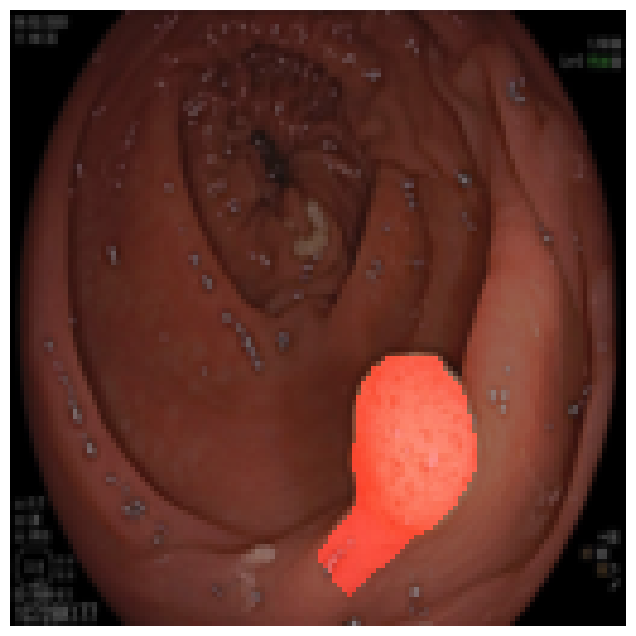

In [ ]:
def plot_image_with_mask(image, mask):
    image = image.permute(1, 2, 0)
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the image
    ax.imshow(image)

    # Create a mask where mask > 0
    mask_rgb = np.zeros_like(image)  # Initialize an array of zeros with the same shape as the image
    mask_rgb[mask > 0] = [1, 0, 0]  # Set mask values greater than 0 to red [R, G, B]

    # Overlay the mask
    ax.imshow(mask_rgb, alpha=0.4)  # Red mask overlay

    ax.axis('off')
    plt.show()


train_dataset = GeneratedPoLypDataset(train_image_paths)
image, mask = train_dataset[-1]
image = image / 255.0
print(f'Image shape: {image.shape}')
print(f'Image min value: {image.min().item()}')
print(f'Image max value: {image.max().item()}')
print(f'Mask shape: {mask.shape}')
print(f'Mask min value: {mask.min().item()}')
print(f'Mask max value: {mask.max().item()}')


# Plot image with mask overlay
plot_image_with_mask(image, mask)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        smooth = 1e-6
        #inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    dice = Dice().to(device)

    for images, masks in tqdm(dataloader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.squeeze(), masks.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        dice.update(outputs, masks)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = dice.compute()

    return epoch_loss, epoch_dice.item()

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    dice = Dice().to(device)

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs.squeeze(), masks.float())

            running_loss += loss.item()
            dice.update(outputs, masks)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = dice.compute()

    return epoch_loss, epoch_dice.item()

def do_one_epoch(
        model,
        train_dataloader,
        val_dataloader,
        optimizer,
        criterion,
        device,
        scheduler=None):

    # Train
    epoch_train_loss, epoch_train_dice = train_epoch(
        model=model,
        dataloader=train_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )
    print(f'Train loss: {epoch_train_loss:.4f}, train dice: {epoch_train_dice:.4f}')

    # Validate
    epoch_val_loss, epoch_val_dice = validate_epoch(
        model=model,
        dataloader=val_dataloader,
        criterion=criterion,
        device=device,
    )
    print(f'Val loss  : {epoch_val_loss:.4f}, val dice: {epoch_val_dice:.4f}')

    # Update learning rate scheduler
    if scheduler is not None:
        scheduler.step(epoch_val_loss)

    # Return losses and metrics of this epoch
    return {
        'epoch_train_loss': epoch_train_loss,
        'epoch_train_dice': epoch_train_dice,
        'epoch_val_loss'  : epoch_val_loss,
        'epoch_val_dice'  : epoch_val_dice,
    }

def test(image_paths, model, device):
    # Dataset
    test_dataset = GeneratedPoLypDataset(image_paths)

    # Dataloader
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    print(f'{len(test_dataset)} test images.')

    # Loss function
    criterion = DiceLoss()

    model.to(device)

    # Loss and metric
    test_loss, test_dice = validate_epoch(
        model=model,
        dataloader=test_dataloader,
        criterion=criterion,
        device=device,
    )

    print(f'Test loss: {test_loss:.4f}')
    print(f'Test dice: {test_dice:.4f}')

In [ ]:
# model

class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm):
        super(unetConv2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, 3, 1, 1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(),
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 1),
                nn.BatchNorm2d(out_size),
                nn.ReLU(),
            )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 1), nn.ReLU())
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 1), nn.ReLU()
            )

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        #print (outputs.shape)
        outputs = self.conv2(outputs)
        #print (outputs.shape)
        return outputs

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, is_batchnorm):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size, out_size, is_batchnorm)

        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)

        return self.conv(torch.cat([outputs1, outputs2], 1))

class UnetSegmentationModel(nn.Module):
    def __init__(self,in_channels, num_classes):
        super().__init__()

        self.in_channels=in_channels
        self.num_classes=num_classes

        #Some config for UNET model
        self.is_batchnorm = True
        self.feature_scale=2
        self.is_deconv = True #Sử dụng Deconvolution hay Upsample layer
        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]

        #DEFINE UNET MODEL
        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv, self.is_batchnorm)
        self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv, self.is_batchnorm)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv, self.is_batchnorm)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv, self.is_batchnorm)

        # final conv (without any concat)
        self.final = nn.Conv2d(filters[0], self.num_classes, 1)

    def forward(self, inputs):
        conv1 = self.conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)

        center = self.center(maxpool4)

        up4 = self.up_concat4(conv4, center)
        up3 = self.up_concat3(conv3, up4)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        final = nn.functional.sigmoid(self.final(up1))

        return final

In [ ]:
def train(train_image_paths, val_image_paths, model, num_epochs, state_dict=None):

    counter     = 0
    patience    = 20

    if state_dict is None:
        print('Training from scratch...')
        best_loss   = np.Inf
        best_dice   = 0.5
        start_epoch = 0
    else:
        print('Continue training...')
        best_loss = state_dict.get('epoch_val_loss')
        best_dice = state_dict.get('epoch_val_dice')
        start_epoch = state_dict.get('epoch')
        model.load_state_dict(state_dict.get('model_state_dict'))

    # Send model to GPU
    model.to(device)

    # Scores of the training and validation
    scores = {
        'train_loss' : [],
        'train_dice' : [],
        'val_loss'   : [],
        'val_dice'   : [],
    }

    # Dataloaders
    train_dataset = GeneratedPoLypDataset(train_image_paths)
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )

    val_dataset = GeneratedPoLypDataset(val_image_paths)
    val_dataloader = DataLoader(
        dataset=val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )

    # Loss function
    criterion = DiceLoss()

    # Adam optimizer
    optimizer = optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE
    )

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # Train
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:')

        epoch_scores = do_one_epoch(
            model,
            train_dataloader,
            val_dataloader,
            optimizer,
            criterion,
            device,
            #scheduler
        )

        epoch_train_loss = epoch_scores.get('epoch_train_loss')
        epoch_train_dice = epoch_scores.get('epoch_train_dice')
        epoch_val_loss   = epoch_scores.get('epoch_val_loss')
        epoch_val_dice   = epoch_scores.get('epoch_val_dice')
        scores['train_loss'].append(epoch_train_loss)
        scores['train_dice'].append(epoch_train_dice)
        scores['val_loss'].append(epoch_val_loss)
        scores['val_dice'].append(epoch_val_dice)

        # Save best model
        is_loss_decreased = epoch_val_loss <= best_loss
        is_dice_increased = epoch_val_dice > best_dice

        if is_loss_decreased and is_dice_increased:
            best_loss = epoch_val_loss
            best_dice = epoch_val_dice
            dice_str = f'{best_dice:.4f}'.replace('.', '')
            save_path = os.path.join(ROOT, 'models', f'unet_real_{dice_str}.pth')
            state_dict = {
                'model_state_dict': model.state_dict(),
                'epoch_val_loss': epoch_val_loss,
                'epoch_val_dice': epoch_val_dice,
                'epoch': epoch,
            }
            torch.save(state_dict, save_path)
            counter = 0  # Reset counter if there's improvement
            print(f'Save best model with best loss: {best_loss:.4f}, best dice: {epoch_val_dice:.4f}')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch}.')
                break

        print('')
    return scores

In [ ]:
model = UnetSegmentationModel(in_channels=3, num_classes=1)
# model_path = os.path.join(ROOT, 'models', 'unet_real_07927.pth')
# state_dict = torch.load(model_path, map_location=device)

# Count the number of learnable parameters
learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {learnable_params}")

Number of learnable parameters: 7765985


In [ ]:
scores = train(
    train_image_paths=train_image_paths,
    val_image_paths=val_image_paths,
    model=model,
    num_epochs=NUM_EPOCHS,
    #state_dict=state_dict
)

Training from scratch...
Epoch 1/200:


Train loss: 0.0062, train dice: 0.3332


Val loss  : 0.0080, val dice: 0.2750

Epoch 2/200:


Train loss: 0.0058, train dice: 0.3986


Val loss  : 0.0079, val dice: 0.2805

Epoch 3/200:


Train loss: 0.0055, train dice: 0.4704


Val loss  : 0.0078, val dice: 0.2786

Epoch 4/200:


Train loss: 0.0053, train dice: 0.5229


Val loss  : 0.0077, val dice: 0.2917

Epoch 5/200:


Train loss: 0.0052, train dice: 0.5314


Val loss  : 0.0073, val dice: 0.3719

Epoch 6/200:


Train loss: 0.0050, train dice: 0.5564


Val loss  : 0.0073, val dice: 0.3748

Epoch 7/200:


Train loss: 0.0048, train dice: 0.5958


Val loss  : 0.0070, val dice: 0.4426

Epoch 8/200:


Train loss: 0.0046, train dice: 0.6038


Val loss  : 0.0066, val dice: 0.5442
Save best model with best loss: 0.0066, best dice: 0.5442

Epoch 9/200:


Train loss: 0.0044, train dice: 0.6367


Val loss  : 0.0066, val dice: 0.4867

Epoch 10/200:


Train loss: 0.0043, train dice: 0.6307


Val loss  : 0.0063, val dice: 0.5135

Epoch 11/200:


Train loss: 0.0041, train dice: 0.6397


Val loss  : 0.0063, val dice: 0.4944

Epoch 12/200:


Train loss: 0.0039, train dice: 0.6503


Val loss  : 0.0062, val dice: 0.5170

Epoch 13/200:


Train loss: 0.0036, train dice: 0.6940


Val loss  : 0.0055, val dice: 0.6220
Save best model with best loss: 0.0055, best dice: 0.6220

Epoch 14/200:


Train loss: 0.0034, train dice: 0.7122


Val loss  : 0.0053, val dice: 0.6601
Save best model with best loss: 0.0053, best dice: 0.6601

Epoch 15/200:


Train loss: 0.0031, train dice: 0.7386


Val loss  : 0.0051, val dice: 0.6354

Epoch 16/200:


Train loss: 0.0029, train dice: 0.7584


Val loss  : 0.0056, val dice: 0.5467

Epoch 17/200:


Train loss: 0.0028, train dice: 0.7607


Val loss  : 0.0047, val dice: 0.6704
Save best model with best loss: 0.0047, best dice: 0.6704

Epoch 18/200:


Train loss: 0.0025, train dice: 0.7754


Val loss  : 0.0041, val dice: 0.7058
Save best model with best loss: 0.0041, best dice: 0.7058

Epoch 19/200:


Train loss: 0.0023, train dice: 0.7902


Val loss  : 0.0050, val dice: 0.5962

Epoch 20/200:


Train loss: 0.0022, train dice: 0.7913


Val loss  : 0.0044, val dice: 0.6790

Epoch 21/200:


Train loss: 0.0019, train dice: 0.8243


Val loss  : 0.0041, val dice: 0.6695

Epoch 22/200:


Train loss: 0.0019, train dice: 0.8197


Val loss  : 0.0042, val dice: 0.6903

Epoch 23/200:


Train loss: 0.0018, train dice: 0.8186


Val loss  : 0.0037, val dice: 0.7225
Save best model with best loss: 0.0037, best dice: 0.7225

Epoch 24/200:


Train loss: 0.0016, train dice: 0.8450


Val loss  : 0.0036, val dice: 0.7242
Save best model with best loss: 0.0036, best dice: 0.7242

Epoch 25/200:


Train loss: 0.0015, train dice: 0.8517


Val loss  : 0.0035, val dice: 0.7186

Epoch 26/200:


Train loss: 0.0014, train dice: 0.8611


Val loss  : 0.0032, val dice: 0.7439
Save best model with best loss: 0.0032, best dice: 0.7439

Epoch 27/200:


Train loss: 0.0014, train dice: 0.8580


Val loss  : 0.0035, val dice: 0.7283

Epoch 28/200:


Train loss: 0.0012, train dice: 0.8782


Val loss  : 0.0036, val dice: 0.7159

Epoch 29/200:


Train loss: 0.0012, train dice: 0.8824


Val loss  : 0.0033, val dice: 0.7246

Epoch 30/200:


Train loss: 0.0012, train dice: 0.8795


Val loss  : 0.0030, val dice: 0.7602
Save best model with best loss: 0.0030, best dice: 0.7602

Epoch 31/200:


Train loss: 0.0011, train dice: 0.8863


Val loss  : 0.0031, val dice: 0.7250

Epoch 32/200:


Train loss: 0.0010, train dice: 0.8989


Val loss  : 0.0028, val dice: 0.7691
Save best model with best loss: 0.0028, best dice: 0.7691

Epoch 33/200:


Train loss: 0.0010, train dice: 0.9024


Val loss  : 0.0029, val dice: 0.7675

Epoch 34/200:


Train loss: 0.0009, train dice: 0.9111


Val loss  : 0.0031, val dice: 0.7503

Epoch 35/200:


Train loss: 0.0009, train dice: 0.9065


Val loss  : 0.0028, val dice: 0.7601

Epoch 36/200:


Train loss: 0.0009, train dice: 0.9091


Val loss  : 0.0028, val dice: 0.7790
Save best model with best loss: 0.0028, best dice: 0.7790

Epoch 37/200:


Train loss: 0.0008, train dice: 0.9180


Val loss  : 0.0027, val dice: 0.7638

Epoch 38/200:


Train loss: 0.0008, train dice: 0.9193


Val loss  : 0.0027, val dice: 0.7782

Epoch 39/200:


Train loss: 0.0007, train dice: 0.9211


Val loss  : 0.0026, val dice: 0.7921
Save best model with best loss: 0.0026, best dice: 0.7921

Epoch 40/200:


Train loss: 0.0007, train dice: 0.9262


Val loss  : 0.0029, val dice: 0.7726

Epoch 41/200:


Train loss: 0.0007, train dice: 0.9261


Val loss  : 0.0028, val dice: 0.7688

Epoch 42/200:


Train loss: 0.0007, train dice: 0.9297


Val loss  : 0.0024, val dice: 0.7948
Save best model with best loss: 0.0024, best dice: 0.7948

Epoch 43/200:


Train loss: 0.0007, train dice: 0.9304


Val loss  : 0.0029, val dice: 0.7628

Epoch 44/200:


Train loss: 0.0006, train dice: 0.9315


Val loss  : 0.0026, val dice: 0.7859

Epoch 45/200:


Train loss: 0.0006, train dice: 0.9332


Val loss  : 0.0025, val dice: 0.7781

Epoch 46/200:


Train loss: 0.0007, train dice: 0.9289


Val loss  : 0.0030, val dice: 0.7598

Epoch 47/200:


Train loss: 0.0007, train dice: 0.9274


Val loss  : 0.0027, val dice: 0.7692

Epoch 48/200:


Train loss: 0.0007, train dice: 0.9227


Val loss  : 0.0035, val dice: 0.7193

Epoch 49/200:


Train loss: 0.0007, train dice: 0.9252


Val loss  : 0.0027, val dice: 0.7855

Epoch 50/200:


Train loss: 0.0006, train dice: 0.9310


Val loss  : 0.0028, val dice: 0.7753

Epoch 51/200:


Train loss: 0.0006, train dice: 0.9311


Val loss  : 0.0025, val dice: 0.7923

Epoch 52/200:


Train loss: 0.0007, train dice: 0.9281


Val loss  : 0.0029, val dice: 0.7598

Epoch 53/200:


Train loss: 0.0007, train dice: 0.9257


Val loss  : 0.0027, val dice: 0.7805

Epoch 54/200:


Train loss: 0.0006, train dice: 0.9339


Val loss  : 0.0026, val dice: 0.7833

Epoch 55/200:


Train loss: 0.0006, train dice: 0.9395


Val loss  : 0.0026, val dice: 0.7887

Epoch 56/200:


Train loss: 0.0006, train dice: 0.9393


Val loss  : 0.0027, val dice: 0.7906

Epoch 57/200:


Train loss: 0.0006, train dice: 0.9395


Val loss  : 0.0026, val dice: 0.7870

Epoch 58/200:


Train loss: 0.0006, train dice: 0.9385


Val loss  : 0.0028, val dice: 0.7595

Epoch 59/200:


Train loss: 0.0005, train dice: 0.9419


Val loss  : 0.0027, val dice: 0.7886

Epoch 60/200:


Train loss: 0.0005, train dice: 0.9420


Val loss  : 0.0026, val dice: 0.7871

Epoch 61/200:


Train loss: 0.0006, train dice: 0.9390


Val loss  : 0.0026, val dice: 0.7854

Epoch 62/200:


Train loss: 0.0005, train dice: 0.9431


Val loss  : 0.0026, val dice: 0.7866
Early stopping at epoch 61.


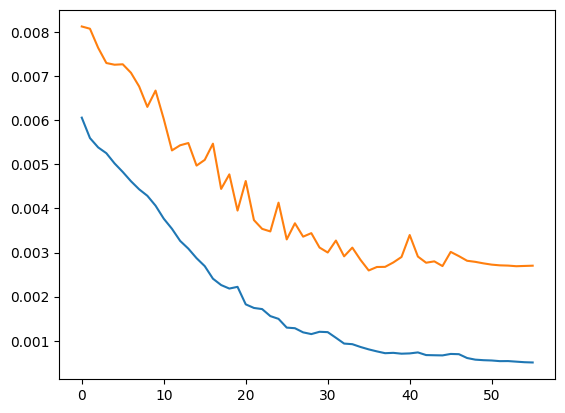

In [ ]:
train_loss = scores.get('train_loss')
train_dice = scores.get('train_dice')
val_loss = scores.get('val_loss')
val_dice = scores.get('val_dice')

plt.plot(train_loss)
plt.plot(val_loss)

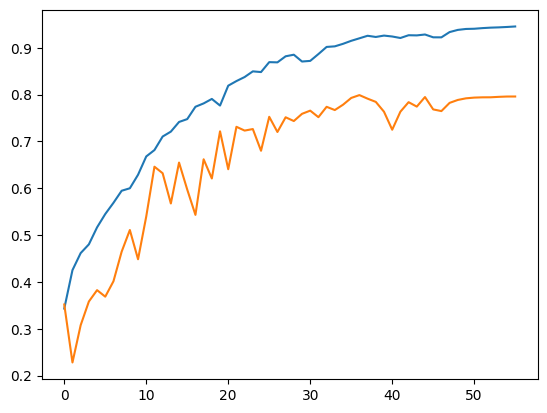

In [ ]:
plt.plot(train_dice)
plt.plot(val_dice)

## Test

In [ ]:
print('Test U-Net trained with real images')
model = UnetSegmentationModel(in_channels=3, num_classes=1)
model_path = os.path.join(ROOT, 'models', 'unet_real_07948.pth')
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict['model_state_dict'])
test(test_image_paths, model, device)

print('-'*30)

print('Test U-Net trained with generated images')
model = UnetSegmentationModel(in_channels=3, num_classes=1)
model_path = os.path.join(ROOT, 'models', 'unet_gen_08545.pth')
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
test(test_image_paths, model, device)

print('-'*30)

print('Test U-Net trained with real and generated images')
model = UnetSegmentationModel(in_channels=3, num_classes=1)
model_path = os.path.join(ROOT, 'models', 'unet_realgen_08874.pth')
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict['model_state_dict'])
test(test_image_paths, model, device)

Test U-Net trained with real images
400 test images.


Test loss: 0.0024
Test dice: 0.7946
------------------------------
Test U-Net trained with generated images
400 test images.


Test loss: 0.0031
Test dice: 0.7058
------------------------------
Test U-Net trained with real and generated images
400 test images.


Test loss: 0.0013
Test dice: 0.8978
